In [1]:
# !pip install torchvision tensorboardx jupyter matplotlib numpy

In [2]:
from IPython import display

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms,datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from utils import Logger

In [4]:
DATA_FOLDER = './torch_data/DCGAN/CIFAR'

In [5]:
def cifar_data():
    compose = transforms.Compose(
      [
       transforms.Resize(64),
       transforms.ToTensor(),
       transforms.Normalize((.5,.5,.5),(.5,.5,.5))
      ]
    )
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir,train=True,transform=compose,download=True)

In [6]:
data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True)
num_batches = len(data_loader)

Files already downloaded and verified


In [7]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet,self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,out_channels=128,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.LeakyReLU(0.2,inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,out_channels=256,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.conv3= nn.Sequential(
            nn.Conv2d(
                in_channels=256,out_channels=512,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,out_channels=1024,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #Flatten and apply sigmoid
        x = x.view(-1,1024*4*4)
        x = self.out(x)
        return x

In [8]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet,self).__init__()

        self.linear = nn.Linear(100,1024*4*4)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024,out_channels=512,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,out_channels=256,kernel_size=4,
                stride=2,padding=1,bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,
                               stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,out_channels=3,kernel_size=4,
                stride=2,padding=1,bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self,x):
        x = self.linear(x)
        x = x.view(x.shape[0],1024,4,4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)

In [9]:
def noise(size):
    n = Variable(torch.randn(size,100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [10]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') !=-1 or classname.find('BatchNorm') !=-1:
        m.weight.data.normal_(0.00,0.02)

In [11]:
generator = GeneratorNet()
generator.apply(init_weights)

discriminator = DiscriminatorNet()
discriminator.apply(init_weights)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [12]:
d_optimizer = Adam(discriminator.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = Adam(generator.parameters(),lr=0.0002,betas=(0.5,0.999))

loss = nn.BCELoss()

num_epochs = 200

In [13]:
def real_data_target(size):
    data = Variable(torch.ones(size,1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size,1))
    if torch.cuda.is_available(): return data.cuda()
    return data
  

In [14]:
def train_discriminator(optimizer,real_data,fake_data):
    #reset gradients
    optimizer.zero_grad()
    
    #1.1 train on real data
    prediction_real = discriminator(real_data)
    # calculate error and backpropagate
    error_real = loss(prediction_real,real_data_target(real_data.size(0)))
    error_real.backward()
    
    # train on fake
    prediction_fake = discriminator(fake_data)
    # calculate error and backpropagate
    error_fake = loss(prediction_fake,fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real+error_fake,prediction_real,prediction_fake

def train_generator(optimizer,fake_data):
    #reset gradients
    optimizer.zero_grad()
    
    #sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    #calculate error and backpropagate
    error = loss(prediction,real_data_target(prediction.size(0)))
    error.backward()
    #update weights with gradients
    optimizer.step()
    return error

In [15]:
num_test_samples = 16
test_noise = noise(num_test_samples)

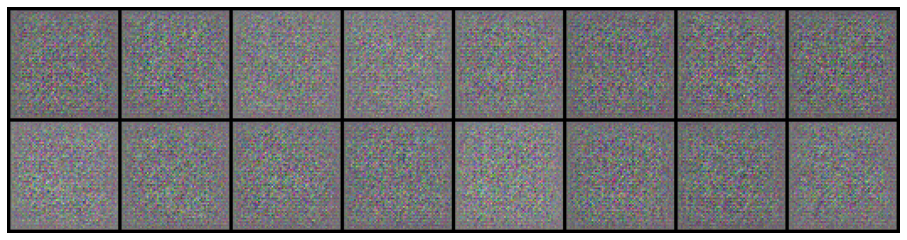

Epoch: [0/200], Batch Num: [0/500]
Discriminator Loss: 1.3855, Generator Loss: 0.7120
D(x): 0.5000, D(G(z)): 0.4996


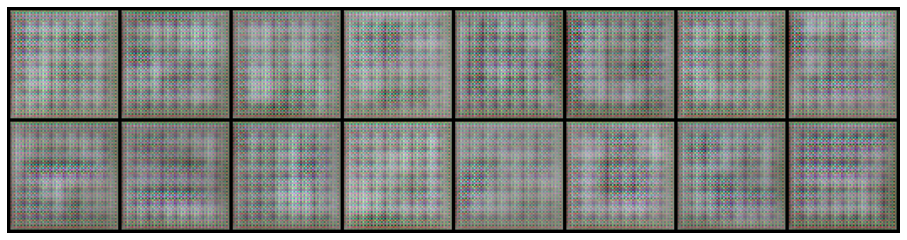

Epoch: [0/200], Batch Num: [100/500]
Discriminator Loss: 0.0382, Generator Loss: 4.6736
D(x): 0.9812, D(G(z)): 0.0189


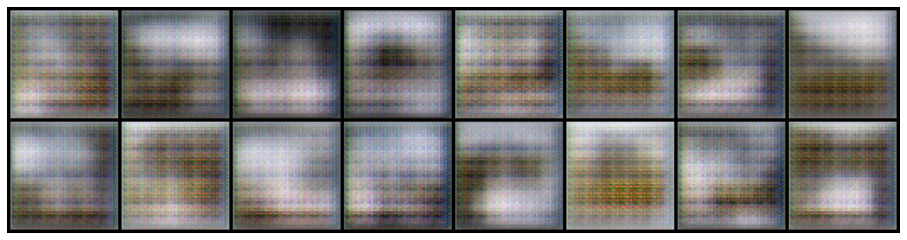

Epoch: [0/200], Batch Num: [200/500]
Discriminator Loss: 0.2482, Generator Loss: 3.4625
D(x): 0.8249, D(G(z)): 0.0299


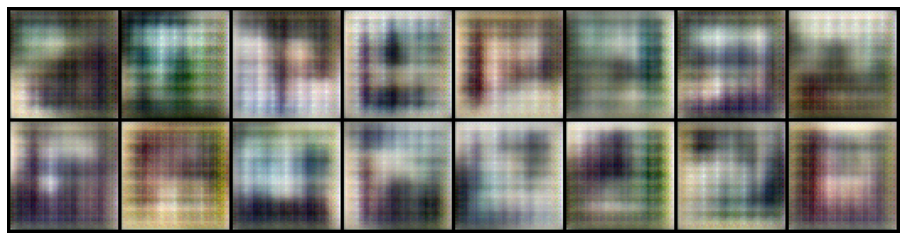

Epoch: [0/200], Batch Num: [300/500]
Discriminator Loss: 0.6437, Generator Loss: 2.3276
D(x): 0.6555, D(G(z)): 0.0578


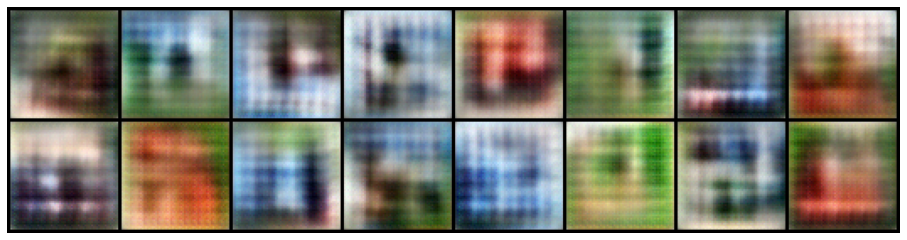

Epoch: [0/200], Batch Num: [400/500]
Discriminator Loss: 0.6386, Generator Loss: 2.9134
D(x): 0.8853, D(G(z)): 0.3805


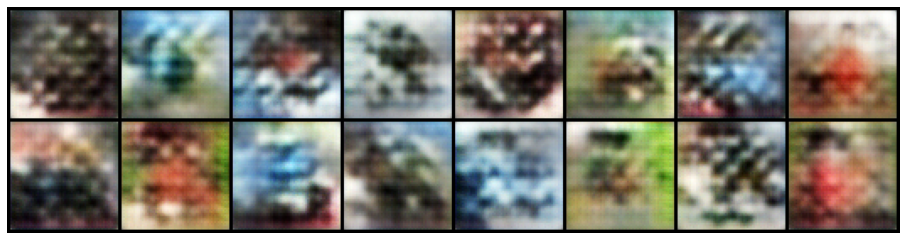

Epoch: [1/200], Batch Num: [0/500]
Discriminator Loss: 1.2716, Generator Loss: 3.1915
D(x): 0.8906, D(G(z)): 0.6374


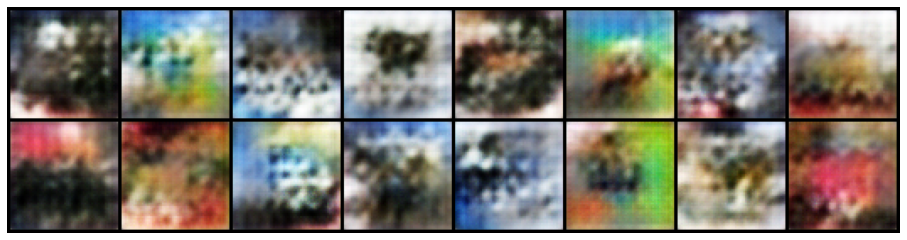

Epoch: [1/200], Batch Num: [100/500]
Discriminator Loss: 0.9032, Generator Loss: 1.6377
D(x): 0.5370, D(G(z)): 0.2119


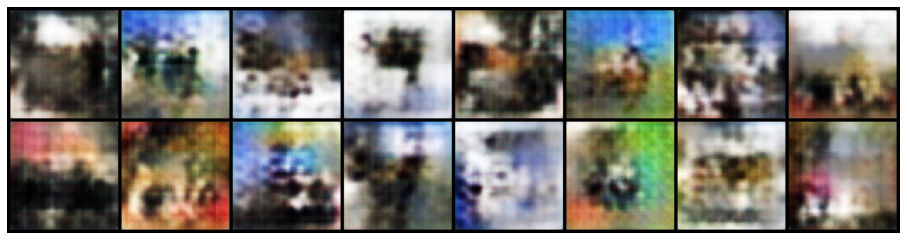

Epoch: [1/200], Batch Num: [200/500]
Discriminator Loss: 1.3167, Generator Loss: 3.4027
D(x): 0.8902, D(G(z)): 0.6611


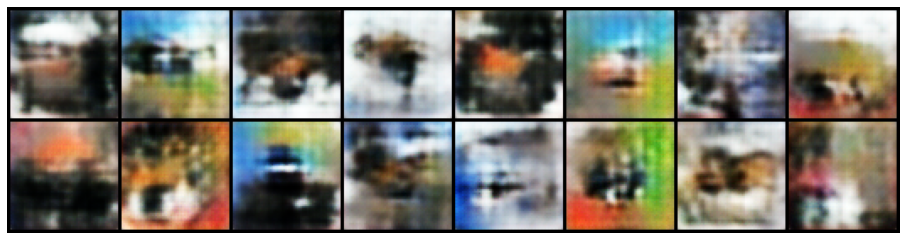

Epoch: [1/200], Batch Num: [300/500]
Discriminator Loss: 0.7749, Generator Loss: 2.9362
D(x): 0.8099, D(G(z)): 0.3980


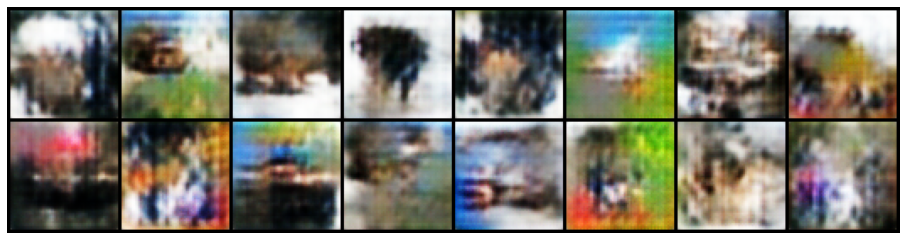

Epoch: [1/200], Batch Num: [400/500]
Discriminator Loss: 0.7741, Generator Loss: 1.3763
D(x): 0.5558, D(G(z)): 0.1309


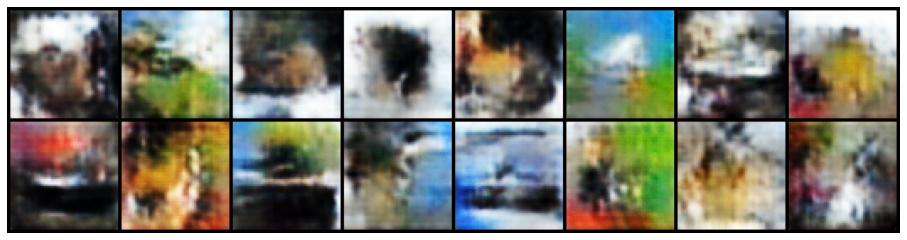

Epoch: [2/200], Batch Num: [0/500]
Discriminator Loss: 1.2010, Generator Loss: 0.4421
D(x): 0.3952, D(G(z)): 0.1520


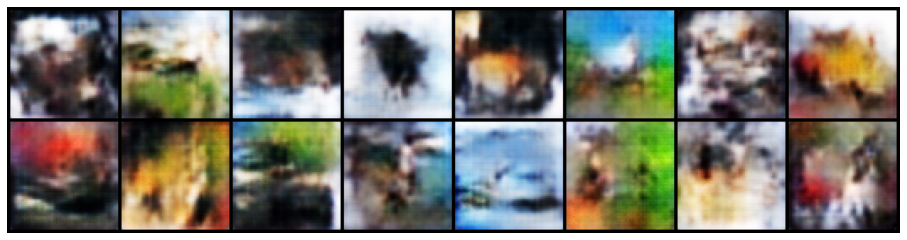

Epoch: [2/200], Batch Num: [100/500]
Discriminator Loss: 0.8050, Generator Loss: 1.4206
D(x): 0.6368, D(G(z)): 0.2628


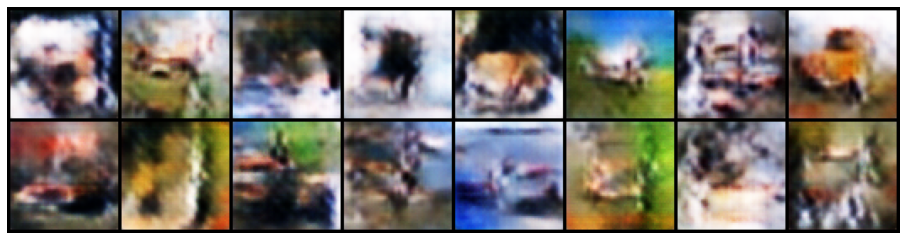

Epoch: [2/200], Batch Num: [200/500]
Discriminator Loss: 1.2905, Generator Loss: 3.1547
D(x): 0.8541, D(G(z)): 0.6524


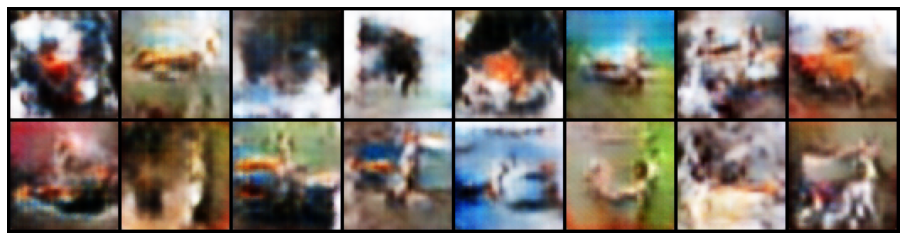

Epoch: [2/200], Batch Num: [300/500]
Discriminator Loss: 1.0499, Generator Loss: 2.6595
D(x): 0.8866, D(G(z)): 0.5815


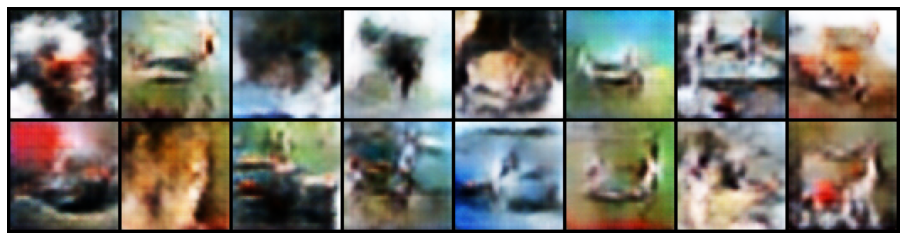

Epoch: [2/200], Batch Num: [400/500]
Discriminator Loss: 1.0950, Generator Loss: 2.6034
D(x): 0.8764, D(G(z)): 0.5936


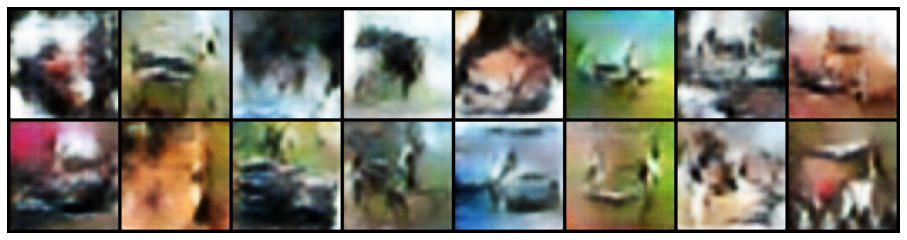

Epoch: [3/200], Batch Num: [0/500]
Discriminator Loss: 0.8432, Generator Loss: 1.7420
D(x): 0.7030, D(G(z)): 0.3704


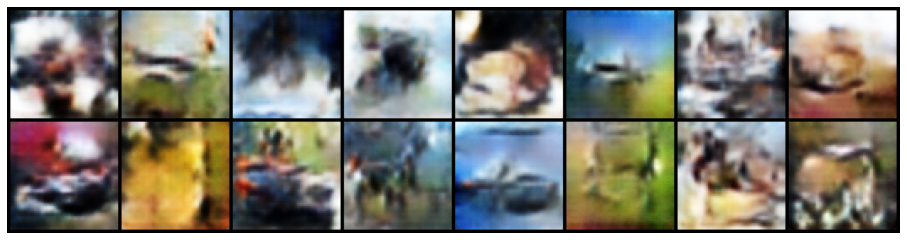

Epoch: [3/200], Batch Num: [100/500]
Discriminator Loss: 0.5639, Generator Loss: 1.7389
D(x): 0.7114, D(G(z)): 0.1852


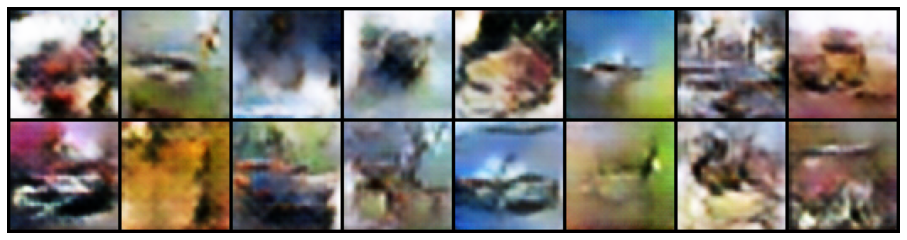

Epoch: [3/200], Batch Num: [200/500]
Discriminator Loss: 0.8879, Generator Loss: 1.4982
D(x): 0.6070, D(G(z)): 0.2952


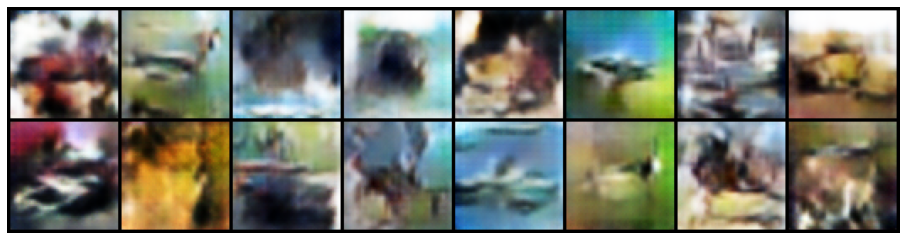

Epoch: [3/200], Batch Num: [300/500]
Discriminator Loss: 0.7109, Generator Loss: 2.1836
D(x): 0.7316, D(G(z)): 0.3104


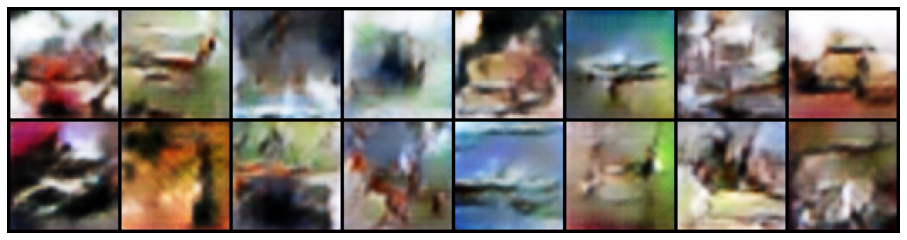

Epoch: [3/200], Batch Num: [400/500]
Discriminator Loss: 0.7968, Generator Loss: 2.0247
D(x): 0.8529, D(G(z)): 0.4533


In [ ]:
logger = Logger(model_name='DCGAN',data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch,(real_batch,_) in enumerate(data_loader):
        
        # Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
            
        #generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        
        d_error,d_pred_real,d_pred_fake = train_discriminator(d_optimizer,real_data,fake_data)
        
        #train generator
        #generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer,fake_data)
        
        #Log error
        logger.log(d_error,g_error,epoch,n_batch,num_batches)
        
        # Display progress
        if (n_batch)%100==0:
#             display.clear_output(True)
            
            #Display Image
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images,num_test_samples,epoch,n_batch,num_batches);
            logger.display_status(
                epoch,num_epochs,n_batch,num_batches,
                d_error,g_error,d_pred_real,d_pred_fake
            )
            logger.save_models(generator,discriminator,epoch)